# Implementing BERT4NILM
**original paper: Yue, Zhenrui, et al. "Bert4nilm: A bidirectional transformer model for non-intrusive load monitoring." Proceedings of the 5th International Workshop on Non-Intrusive Load Monitoring. 2020**

**author: Bousbiat Hafsa**

BERT4NILM  is model that is based on bidirectional attention mechanism. In the original, the model was proposed to



![bertarchitecture](./images/bert4nilm.jpg)


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import deep_nilmtk.data.loader.pytorch.bert_dataloader
from deep_nilmtk.models.pytorch import S2S
from deep_nilmtk.models.pytorch.layers import create_conv1, create_linear, create_deconv1
import matplotlib.pyplot as plt

## Model Implementation

### Positional Embedding



In [2]:
# The original code was taken from the
# the repo: https://github.com/Yueeeeeeee/BERT4NILM/
# Paper Link: https://dl.acm.org/doi/pdf/10.1145/3427771.3429390

import math
import torch
from torch import nn
import torch.nn.functional as F

from tqdm import tqdm
import sys


from torch.nn import TransformerEncoderLayer

import math
import torch
from torch import nn
import torch.nn.functional as F


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(
            query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.activation(self.w_1(x)))


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))


class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(
            h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(
            d_model=hidden, d_ff=feed_forward_hidden)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(
            x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

class BERT4NILM(nn.Module):
    """
    .. _bert:
    BERT4NILM implementation.
    Original paper can be found here: https://dl.acm.org/doi/pdf/10.1145/3427771.3429390
    Original code can be found here: https://github.com/Yueeeeeeee/BERT4NILM
    The hyperparameter dictionnary is expected to include the following parameters

    :param threshold:  The threshold for states generation in the target power consumption, defaults to None
    :type threshold: List of floats
    :param cutoff: The cutoff for states generation in the target power consumption, defaults to None
    :type cutoff: List of floats
    :param min_on: The min on duration for states generation in the target power consumption, defaults to None
    :type min_on: List of floats
    :param min_off: The min off duration for states generation in the target power consumption, defaults to None
    :type min_off: List of floats
    :param in_size: The length of the input sequence, defaults to 488.
    :type in_size: int
    :param stride: The distance between two consecutive sequences, defaults to 1.
    :type stride: int
    :param hidden: The hidden size, defaults to 256
    :type hidden: int
    :param heads: The number of attention heads in each transformer block, defaults to 2
    :type heads: int
    :param n_layers: the number of transformer blocks in the model, defaults to 2
    :type n_layers: int
    :params dropout: The dropout, defaults to 0.2
    :type dropout: float
    it can be used as follow:
    .. code-block:: python
        'Bert4NILM': NILMExperiment({
                  "model_name": 'BERT4NILM',
                  'in_size': 480,
                  'feature_type':'main',
                  'stride':10,
                  'max_nb_epochs':1,
                  'cutoff':{
                      'aggregate': 6000,
                      'kettle': 2500,
                      'fridge': 300,
                      'washing machine': 2500,
                      'microwave': 3000,
                      'dishwasher': 2500
                  },
                  'threshold':{
                     'kettle': 2000,
                     'fridge': 50,
                     'washing machine': 20,
                     'microwave': 200,
                     'dishwasher': 10
                  },
                  'min_on':{
                    'kettle': 2,
                    'fridge': 10,
                    'washing machine': 300,
                    'microwave': 2,
                    'dishwasher': 300
                  },
                  'min_off':{
                      'kettle': 0,
                      'fridge': 2,
                      'washing machine': 26,
                      'microwave': 5,
                      'dishwasher': 300
                  },
                })
    """

    def __init__(self, params):
        
        super().__init__()
   
        self.original_len = params['in_size'] if 'in_size' in params else 99
        self.output_size = len(params['appliances']) if params['multi_appliance'] else 1
        self.stride = params['stride'] if 'stride' in params else 1

        # The original mode was proposed for several appliances
        self.threshold = [params['threshold'][params['appliances'][0]]] if 'threshold' in params else None

        self.cutoff = [params['cutoff'][params['appliances'][0]]] if 'cutoff' in params else None

        self.min_on = [params['min_on'][params['appliances'][0]]] if 'min_on' in params else None
        self.min_off = [params['min_off'][params['appliances'][0]]] if 'min_off' in params else None

        # self.C0 = [params['lambda'][params['appliances'][0]]] if 'lambda' in params else [1e-6]

        self.main_mu = params['main_mu']
        self.main_std = params['main_std']

        self.set_hpramas(self.cutoff, self.threshold, self.min_on, self.min_off)

        self.C0 = torch.tensor([params['c0'] if 'c0' in params else .3])

        self.latent_len = int(self.original_len / 2)
        self.dropout_rate = params['dropout'] if 'dropout' in params else 0.2

        self.hidden = params['hidden'] if 'hidden' in params else 64
        self.heads = params['heads'] if 'heads' in params else 2
        self.n_layers = params['n_layers'] if 'n_layers' in params else 2

        self.conv = create_conv1(in_channels=1, out_channels=self.hidden,
                                 kernel_size=5, stride=1, padding=2, padding_mode='replicate')

        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)



        self.transformer_blocks = nn.ModuleList([TransformerBlock(
            self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])

        self.deconv = create_deconv1(
            in_channels=self.hidden, out_channels=self.hidden, kernel_size=4, stride=2, padding=1,
            output_padding=0 if self.original_len % 2 == 0 else 1)
        self.linear1 = create_linear(self.hidden, 128)
        self.linear2 = create_linear(128, self.output_size)

        self.activation = nn.Sigmoid()

        self.kl = nn.KLDivLoss(reduction='batchmean')
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss(reduction='mean')
        self.margin = nn.SoftMarginLoss()
        self.l1_on = nn.L1Loss(reduction='sum')

    def forward(self, sequence):
        x_token = self.pool(self.conv(sequence.float().unsqueeze(1))).permute(0, 2, 1)

        embedding = x_token + self.position(sequence)
        x = self.dropout(self.layer_norm(embedding))

        mask = None
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.deconv(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)

        return x

    def step(self, batch, seq_type=None):
        """Disaggregates a batch of data
        :param batch: A batch of data.
        :type batch: Tensor
        :return: loss function as returned form the model and MAE as returned from the model.
        :rtype: tuple(float,float)
        """
        seqs, labels_energy, status = batch


        batch_shape = status.shape

        logits = self.forward(seqs)

        labels = labels_energy / self.cutoff.to(seqs.device)  # This the normalization of the output data ?!!!

        logits_energy = self.cutoff_energy(logits * self.cutoff.to(seqs.device))
        logits_status = self.compute_status(logits_energy)


        mask = (status > 0).to(seqs.device)

        labels_masked = torch.masked_select(labels, mask).view((-1, batch_shape[-1])).float()
        logits_masked = torch.masked_select(logits, mask).view((-1, batch_shape[-1])).float()
        status_masked = torch.masked_select(status, mask).view((-1, batch_shape[-1])).float()
        logits_status_masked = torch.masked_select(logits_status, mask).view((-1, batch_shape[-1])).float()

        # Calculating the Loss function
        kl_loss = self.kl(torch.log(F.softmax(logits_masked.squeeze() / 0.1, dim=-1) + 1e-9),
                          F.softmax(labels_masked.squeeze() / 0.1, dim=-1))
        # print(f'margin:{kl_loss}')
        mse_loss = self.mse(logits_masked.contiguous().view(-1),
                            labels_masked.contiguous().view(-1))
        # print(f'margin:{mse_loss}')
        margin_loss = self.margin((logits_status_masked * 2 - 1).contiguous().view(-1),
                                  (status_masked * 2 - 1).contiguous().view(-1))
        # print(f'margin:{margin_loss}')
        total_loss = kl_loss + mse_loss + margin_loss
        on_mask = (status >= 0) * (((status == 1) + (status != logits_status)) >= 1)
        if on_mask.sum() > 0:
#             print(f'this is the mask ON {on_mask.sum()}')
            total_size = torch.tensor(on_mask.shape).prod()
            logits_on = torch.masked_select(logits.reshape(on_mask.shape), on_mask)
            labels_on = torch.masked_select(labels.reshape(on_mask.shape), on_mask)
            loss_l1_on = self.l1_on(logits_on.contiguous().view(-1),
                                    labels_on.contiguous().view(-1))
            total_loss += self.C0.to(seqs.device)[0] * loss_l1_on / total_size

        mae = self.mae(logits_masked.contiguous().view(-1),
                       labels_masked.contiguous().view(-1))
        print(total_loss)
        return total_loss, mae

    def set_hpramas(self, cutoff, threshold, min_on, min_off):
        """
        Setter for the hyper-parameters related to appliance state generation
        :param cutoff: The power cutoff
        :type cutoff: float
        :param threshold: Threshold of target power consumption
        :type threshold: float
        :param min_on: Minimum on duration
        :type min_on: float
        :param min_off: Minimum off duration
        :type min_off: float
        """
        if cutoff is not None:
            self.cutoff = torch.tensor(cutoff)
        if threshold is not None:
            self.threshold = torch.tensor(threshold)
        if min_on is not None:
            self.min_on = torch.tensor(min_on)
        if min_off is not None:
            self.min_off = torch.tensor(min_off)

    def cutoff_energy(self, data):
        """
        Removes the spikes from the data
        :param data: Power consumption
        :type data: tesnor
        :return: Updated ower consumption
        :rtype: tensor
        """
        columns = data.squeeze().shape[-1]

        if self.cutoff.size(0) == 0:
            self.cutoff = torch.tensor(
                [3100 for i in range(columns)])

        data[data < 5] = 0

        data = torch.min(data, self.cutoff.to(data.device))
        return data

    def compute_status(self, data):
        """
        Calculates teh states for the  target data based on the threshold
        :param data: The target data
        :type data: tensor
        :return: The operational states
        :rtype: tensor
        """
        data_shape = data.shape
        columns = data.shape[-1]

        if self.threshold.size(0) == 0:
            self.threshold = torch.tensor(
                [10 for i in range(columns)])

        status = (data >= self.threshold.to(data.device)) * 1

        return status

    def predict(self, model, test_dataloader):
        """Generates predictions for the test data loader
        :param model: Pre-trained model
        :type model: nn.Module
        :param test_dataloader: The test data
        :type test_dataloader: dataLoader
        :return: Generated predictions
        :rtype: dict
        """

        net = model.model.eval()
        num_batches = len(test_dataloader)
        values = range(num_batches)

        pred = []

        e_pred_curve = []
        s_pred_curve = []

        true = []

        with tqdm(total=len(values), file=sys.stdout) as pbar:
            with torch.no_grad():
                for batch_idx, batch in enumerate(test_dataloader):
                    seqs = batch

                    logits = self.forward(seqs)

                    true.append(seqs)

                    logits_energy = self.cutoff_energy(logits * self.cutoff.to(seqs.device))  # Denormalization
                    logits_status = self.compute_status(logits_energy)

                    status = (logits_status > 0) * 1

                    s_pred_curve.append(status)
                    e_pred_curve.append(logits_energy * status)

                    del batch
                    pbar.set_description('processed: %d' % (1 + batch_idx))
                    pbar.update(1)

                pbar.close()

        # TODO: Denormalisation !!! Previously done ?
        e_pred_curve = torch.cat(e_pred_curve, 0).detach().numpy()
        s_pred_curve = torch.cat(s_pred_curve, 0).detach().numpy()


        results = {
            "pred": e_pred_curve * s_pred_curve,
            "s_pred_curve": s_pred_curve
        }

        return results

    @staticmethod
    def get_template(self):
        return {
                  "model_name": 'BERT4NILM',
                  'in_size': 480,
                  'feature_type':'main',
                  'stride':10,
                  'cutoff':{
                      'aggregate': 6000,
                      'kettle': 1500,
                      'fridge': 300,
                      'washing machine': 2500,
                      'microwave': 3000,
                      'dishwasher': 2500
                  },
                  'threshold':{
                     'kettle': 2000,
                     'fridge': 50,
                     'washing machine': 20,
                     'microwave': 200,
                     'dishwasher': 10
                  },
                  'min_on':{
                    'kettle': 2,
                    'fridge': 10,
                    'washing machine': 300,
                    'microwave': 2,
                    'dishwasher': 300
                  },
                  'min_off':{
                      'kettle': 0,
                      'fridge': 2,
                      'washing machine': 26,
                      'microwave': 5,
                      'dishwasher': 300
                  },
                }

In [4]:
from deep_nilmtk.disaggregator import NILMExperiment
from deep_nilmtk.models.pytorch import UNETNILM
from deep_nilmtk.data.loader.pytorch import GeneralDataLoader
from deep_nilmtk.utils.templates import ExperimentTemplate

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

DATA_PATH = '../../data/ukdale.h5'
EXPERIMENT_NAME = 'unet_with_baselines'
RESULTS_PATH = '../../unet_with_baselines'

template = ExperimentTemplate( data_path=DATA_PATH,
                 template_name='ukdale_3',
                 list_appliances=['washing machine'],
                 list_baselines_backends=[],
                 in_sequence=121,
                 out_sequence=1,
                 max_epochs=1)
from deep_nilmtk.data.loader.pytorch import BERTDataset

bertnilm =  NILMExperiment({
                "model_class": BERT4NILM,
                "loader_class": BERTDataset,
                "model_name": 'bert101',
                'backend':'pytorch',
                'in_size': 480,
                'out_size':480,
                'custom_preprocess':None,
                'feature_type':'mains',
                'input_norm':'z-norm',
                'target_norm':None,
                'seq_type':'seq2seq',
                'learning_rate':10e-5,
                'stride':10,
                  'cutoff':{
                      'aggregate': 6000,
                      'kettle': 1500,
                      'fridge': 300,
                      'washing machine': 2500,
                      'microwave': 3000,
                      'dishwasher': 2500
                  },
                  'threshold':{
                     'kettle': 2000,
                     'fridge': 50,
                     'washing machine': 20,
                     'microwave': 200,
                     'dishwasher': 10
                  },
                  'min_on':{
                    'kettle': 2,
                    'fridge': 10,
                    'washing machine': 300,
                    'microwave': 2,
                    'dishwasher': 300
                  },
                  'min_off':{
                      'kettle': 0,
                      'fridge': 2,
                      'washing machine': 26,
                      'microwave': 5,
                      'dishwasher': 300
                  },
         
                })
template.extend_experiment({
    'bert101':bertnilm
})

template.run_template(EXPERIMENT_NAME,
                      RESULTS_PATH,
                      f'{RESULTS_PATH}/mlflow')

Joint Testing for all algorithms
Loading data for  ukdale  dataset


Dropping missing values
Generating predictions for : bert101
(308907, 1)
(308907, 1)
(308907, 1)
  0%|                                                                                                                                                                                     | 0/482 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [4]:
pe = PositionalEmbedding(256, 240)
x = torch.Tensor([64,1,480])
ps_enc = pe.pe.weight.detach().numpy()

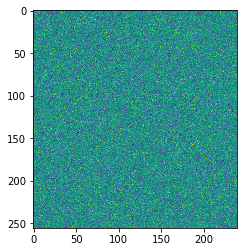

In [29]:
plt.imshow(ps_enc)
plt.show()

### The transformer block

In [45]:
class TransformerBlock(nn.Module):
    """
    Tranformer decoder block.
    :param hidden: Dimension of the model
    :type hidden: int
    :param attn_heads: The number of attention heads
    :type attn_heads: int
    :param feed_forward_hidden: The hidden size of feedforward layer
    :type feed_forward_hidden: int
    :param dropout: Dropout
    :type dropout: float
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(
            h=attn_heads, d_model=hidden, dropout=dropout)

        self.feed_forward = PositionwiseFeedForward(
            d_model=hidden, d_ff=feed_forward_hidden)

        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(
            x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


### The final model

In [5]:
class BERT4NILM(S2S):
    def __init__(self):
        # The encoder block
        self.encoder = nn.Sequential(
            create_conv1(in_channels=1, out_channels=self.hidden,
                                 kernel_size=5, stride=1, padding=2, padding_mode='replicate'),
            nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        )
        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        # The core of the bert
        self.transformer_block = nn.ModuleList([TransformerEncoderLayer(
            self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])
        # The decoder part
        self.decoder = nn.Sequential(
            create_deconv1(
                in_channels=self.hidden, out_channels=self.hidden, kernel_size=4, stride=2, padding=1,
                output_padding=0 if self.original_len % 2 == 0 else 1),
            create_linear(self.hidden, 128),
            create_linear(128, self.output_size)
        )

    def forward(self, batch):
        x = self.encoder(batch) + self.position(batch)
        x = self.transformer_block(x)
        x = self.decoder(x)
        return x

    def step(self, batch):
        pass

    def predict(self,  model, test_dataloader):
        pass





## Data Loaders

In [19]:


template.__print__()

"
        The current experiment is based on template ukdale_3
        Appliances ['washing machine']
        NILM MODELS ['bert101']
        Dataset path ../../data/ukdale.h5
            - sampling rate :8
            - training data 
                - uses following buildings 1
                - uses following buildings 1
            - testing data
                - uses following buildings 1
        


run unet_with_baselines
Started training for  bert101
Joint training for  bert101
............... Loading Data for training ...................
Loading data for  ukdale  dataset
Loading building ...  1


Dropping missing values
{'use_optuna': False, 'log_artificat': False, 'max_nb_epochs': 1, 'n_trials': 3, 'batch_size': 64, 'clip_value': 10, 'learning_rate': 0.0001, 'eps': 1e-08, 'dropout': 0.25, 'pool_filter': 16, 'kernel_size': 5, 'stride': 1, 'features_start': 16, 'latent_size': 64, 'num_gauss': 5, 'min_std': 0.1, 'n_layers': 4, 'out_size': 480, 'in_size': 480, 'border': 0, 'multi_appliance': False, 'custom_preprocess': None, 'custom_postprocess': None, 'patience_optim': 5, 'patience_check': 5, 'num_layer': 3, 'experiment_label': '', 'optimizer': 'adam', 'weight_decay': 0.0, 'momentum': None, 'decay_step': 100, 'gamma': 0.1, 'feature_type': 'mains', 'alpha': 0.1, 'seed': 3407, 'main_mu': 150.0, 'main_std': 350.0, 'input_norm': 'z-norm', 'q_filter': None, 'sample_second': 6, 'seq_type': 'seq2seq', 'point_position': 'last_position', 'target_norm': None, 'threshold_method': 'at', 'model_class': <class '__main__.BERT4NILM'>, 'loader_class': <class 'deep_nilmtk.data.loader.pytorch.bert_

2022/03/31 12:35:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | BERT4NILM | 240 K 
------------------------------------
240 K     Trainable params
0         Non-trainable params
240 K     Total params
0.963     Total estimated model params size (MB)


Validation sanity check:   0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'to'

In [44]:
{**{'app':12}, **{'app2':12},}

{'app': 12, 'app2': 12}